# Gold/Silver Forecasting

In [2]:
import torch
import numpy as np
from torch import nn
import math, time
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import gc

# For interactive visualization, not good for too many datapoints
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go


In [3]:
# This data was obtained through https://www.investing.com/commodities/metals
silver = pd.read_csv('datasets/Finance/Silver Futures Historical Data.csv')
gold = pd.read_csv('datasets/Finance/Gold Futures Historical Data.csv')
copper = pd.read_csv('datasets/Finance/Copper Futures Historical Data.csv')
palladium = pd.read_csv('datasets/Finance/Palladium Futures Historical Data.csv')
platinum = pd.read_csv('datasets/Finance/Platinum Futures Historical Data.csv')

In [4]:
silver.tail()

Date   Price    Open    High     Low    Vol. Change %
2600  02/01/2013  31.988  31.615  32.095  31.605   0.01K    1.94%
2601  01/31/2013  31.380  31.470  31.845  31.190   0.00K   -2.66%
2602  01/30/2013  32.237  31.405  32.350  31.330   2.54K    3.38%
2603  01/29/2013  31.184  30.850  31.470  30.850  32.35K    1.31%
2604  01/28/2013  30.780  31.160  31.320  30.745  37.83K   -1.37%

In [5]:
len(silver), len(gold), len(copper), len(palladium), len(platinum)

(2605, 2619, 2612, 2878, 3137)

In [6]:
# Check Inflation Data
# https://www.kaggle.com/datasets/varpit94/us-inflation-data-updated-till-may-2021
inflation = pd.read_csv('datasets/Finance/us cpi/US CPI.csv')
inflation

Yearmon      CPI
0     01-01-1913    9.800
1     01-02-1913    9.800
2     01-03-1913    9.800
3     01-04-1913    9.800
4     01-05-1913    9.700
...          ...      ...
1298  01-03-2021  264.877
1299  01-04-2021  267.054
1300  01-05-2021  269.195
1301  01-06-2021  271.696
1302  01-07-2021  273.003

[1303 rows x 2 columns]

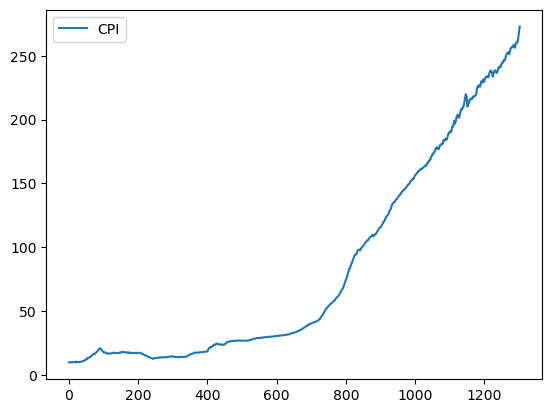

In [7]:
inflation.plot();

In [8]:
# https://www.kaggle.com/datasets/federalreserve/interest-rates
fedrates = pd.read_csv('datasets/Finance/federalreserverates/index.csv')
fedrates

Year  Month  Day  Federal Funds Target Rate  Federal Funds Upper Target  \
0    1954      7    1                        NaN                         NaN   
1    1954      8    1                        NaN                         NaN   
2    1954      9    1                        NaN                         NaN   
3    1954     10    1                        NaN                         NaN   
4    1954     11    1                        NaN                         NaN   
..    ...    ...  ...                        ...                         ...   
899  2016     12   14                        NaN                        0.75   
900  2017      1    1                        NaN                        0.75   
901  2017      2    1                        NaN                        0.75   
902  2017      3    1                        NaN                        0.75   
903  2017      3   16                        NaN                        1.00   

     Federal Funds Lower Target  Effective Federal Funds Rate  \
0                           NaN                          0.80   
1                           NaN                          1.22   
2                           NaN                          1.06   
3                           NaN                          0.85   
4                           NaN                          0.83   
..                          ...                           ...   
899                        0.50                           NaN   
900                        0.50                          0.65   
901                        0.50                          0.66   
902                        0.50                           NaN   
903                        0.75                           NaN   

     Real GDP (Percent Change)  Unemployment Rate  Inflation Rate  
0                          4.6                5.8             NaN  
1                          NaN                6.0             NaN  
2                          NaN                6.1             NaN  
3                          8.0                5.7             NaN  
4                          NaN                5.3             NaN  
..                         ...                ...             ...  
899                        NaN                NaN             NaN  
900                        NaN                4.8             2.3  
901                        NaN                4.7             2.2  
902                        NaN                NaN             NaN  
903                        NaN                NaN             NaN  

[904 rows x 10 columns]

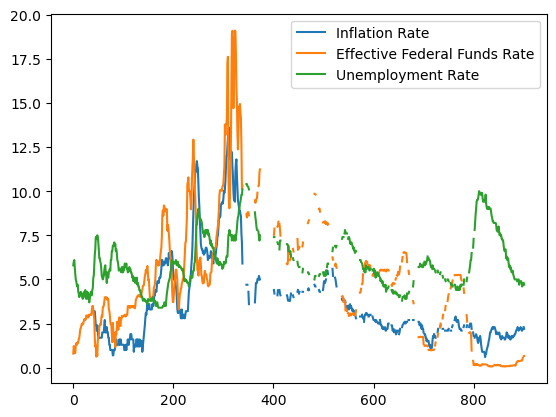

In [9]:
fedrates[['Inflation Rate', 'Effective Federal Funds Rate', 'Unemployment Rate']].plot();

### Missing Data

- Vol has too many missing values so I'm avoiding it.

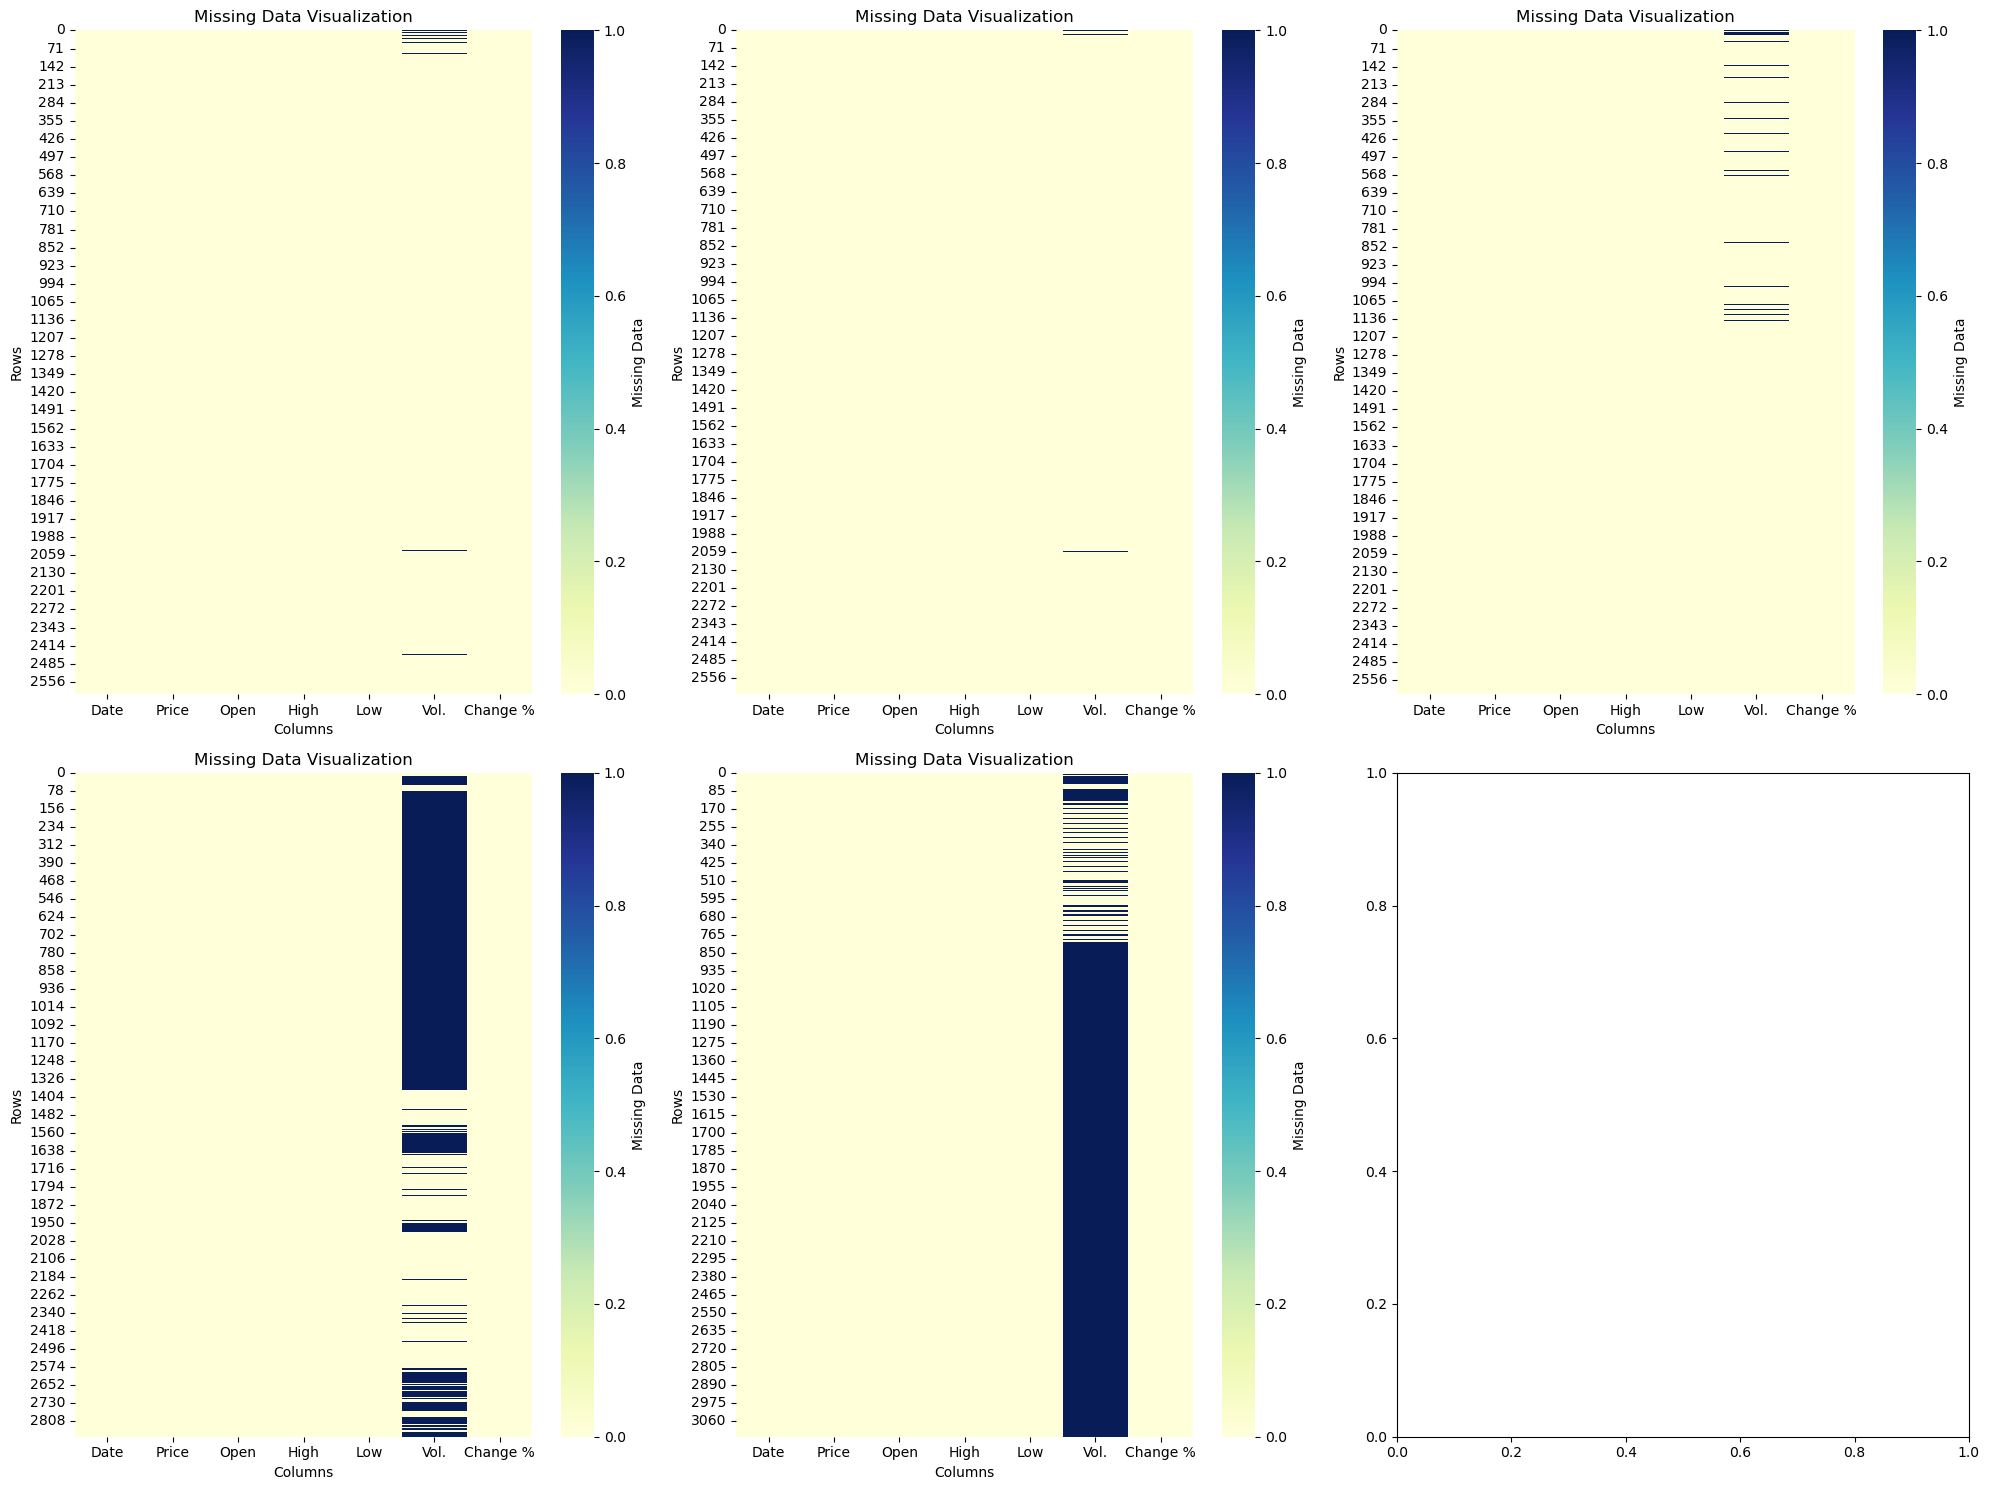

In [10]:
dfs_list = [silver, gold, copper, palladium, platinum]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))

for df, ax in zip(dfs_list, axes.flatten()):
    sns.heatmap(df.isna(),
                cmap="YlGnBu",
                cbar_kws={'label': 'Missing Data'},
                ax=ax)
    ax.set_title("Missing Data Visualization")
    ax.set_xlabel("Columns")
    ax.set_ylabel("Rows")

plt.tight_layout()
plt.show()

In [11]:
silver = silver.drop(columns='Vol.')
gold = gold.drop(columns='Vol.')
copper = copper.drop(columns='Vol.')
palladium = palladium.drop(columns='Vol.')
platinum = platinum.drop(columns='Vol.')
print('Removed Vol.')

Removed Vol.


### Addressing the data type problems
 * , for thousand units
 * %

In [12]:
def stringToNumber(data):
    df = data.copy()
    cols = df.columns
    for c in cols:
        if df[c].dtype == 'object':
            df[c] = df[c].str.replace('%', '')  # Remove percentage symbols
            df[c] = df[c].str.replace(',', '')  # Remove thousand separators
            df[c] = df[c].astype(float)  # Convert to float
    return df

silver[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(silver[['Price', 'Open', 'High', 'Low', 'Change %']])
gold[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(gold[['Price', 'Open', 'High', 'Low', 'Change %']])
copper[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(copper[['Price', 'Open', 'High', 'Low', 'Change %']])
palladium[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(palladium[['Price', 'Open', 'High', 'Low', 'Change %']])
platinum[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(platinum[['Price', 'Open', 'High', 'Low', 'Change %']])
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2619 entries, 0 to 2618
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2619 non-null   object 
 1   Price     2619 non-null   float64
 2   Open      2619 non-null   float64
 3   High      2619 non-null   float64
 4   Low       2619 non-null   float64
 5   Change %  2619 non-null   float64
dtypes: float64(5), object(1)
memory usage: 122.9+ KB


In [13]:
# Format date
silver['Date'] = pd.to_datetime(silver['Date'], format='%m/%d/%Y')
gold['Date'] = pd.to_datetime(gold['Date'], format='%m/%d/%Y')
copper['Date'] = pd.to_datetime(copper['Date'], format='%m/%d/%Y')
palladium['Date'] = pd.to_datetime(palladium['Date'], format='%m/%d/%Y')
platinum['Date'] = pd.to_datetime(platinum['Date'], format='%m/%d/%Y')

- If we take a look at the data, there is an inconsistency with the dates. Sometimes it has less sundays, sometimes more, it could be related to global changes in different times or market behaviour.
- There are no saturdays.

In [14]:
def countSundays(dfs):
    for index, d in enumerate(dfs):
        a = d.copy()
        a['Day'] = a['Date'].dt.day_name()
        print(index, a['Day'].value_counts()['Sunday'])
countSundays([silver, gold, copper, palladium, platinum])

0 15
1 3
2 21
3 247
4 517


In [15]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

print(silver.shape[0])
date_range = pd.date_range(
    platinum['Date'].min(), 
    platinum['Date'].max(), freq=us_bd)
date_df = pd.DataFrame({'Date': date_range})
print(date_df.shape[0])
print('\n')
print(silver[~silver['Date'].isin(date_df['Date'])].shape)
print(gold[~gold['Date'].isin(date_df['Date'])].shape)
print(copper[~copper['Date'].isin(date_df['Date'])].shape)
print(palladium[~palladium['Date'].isin(date_df['Date'])].shape)
print(platinum[~platinum['Date'].isin(date_df['Date'])].shape)
print('\n')
print(date_df[~date_df['Date'].isin(silver['Date'])].shape)
print(date_df[~date_df['Date'].isin(gold['Date'])].shape)
print(date_df[~date_df['Date'].isin(copper['Date'])].shape)
print(date_df[~date_df['Date'].isin(palladium['Date'])].shape)
print(date_df[~date_df['Date'].isin(platinum['Date'])].shape)


2605
2529


(101, 6)
(99, 6)
(89, 6)
(356, 6)
(615, 6)


(25, 1)
(9, 1)
(6, 1)
(7, 1)
(7, 1)


## Data Imputation

In [16]:
date_range = pd.date_range(
    min(silver['Date'].min(), platinum['Date'].min()), 
    max(silver['Date'].max(), platinum['Date'].max()), freq=us_bd
)

date_df = pd.DataFrame({'Date': date_range})

print(
    min(silver['Date'].min(), silver['Date'].min()), 
    max(silver['Date'].max(), silver['Date'].max())
)

merged_df_silver = pd.merge(date_df, silver, how='left', on='Date')
merged_df_gold = pd.merge(date_df, gold, how='left', on='Date')
merged_df_copper = pd.merge(date_df, copper, how='left', on='Date')
merged_df_palladium = pd.merge(date_df, palladium, how='left', on='Date')
merged_df_platinum = pd.merge(date_df, platinum, how='left', on='Date')

print("\nMissing values of silver:   ", merged_df_silver['Price'].isnull().sum())
print("Missing values of gold:      ", merged_df_gold['Price'].isnull().sum())
print("Missing values of copper:    ", merged_df_copper['Price'].isnull().sum())
print("Missing values of palladium: ", merged_df_palladium['Price'].isnull().sum())
print("Missing values of platinum:  ", merged_df_platinum['Price'].isnull().sum())

2013-01-28 00:00:00 2023-02-28 00:00:00

Missing values of silver:    25
Missing values of gold:       9
Missing values of copper:     6
Missing values of palladium:  7
Missing values of platinum:   7


In [17]:
imputer = SimpleImputer(strategy='mean')

columns = merged_df_silver.columns[1:]

imputed_df_silver = merged_df_silver.copy()
imputed_df_gold = merged_df_gold.copy()
imputed_df_copper = merged_df_copper.copy()
imputed_df_palladium = merged_df_palladium.copy()
imputed_df_platinum = merged_df_platinum.copy()

for c in columns:
    imputed_df_silver[c] = imputed_df_silver[c].interpolate(method='linear')
    imputed_df_gold[c] = imputed_df_gold[c].interpolate(method='linear')
    imputed_df_copper[c] = imputed_df_copper[c].interpolate(method='linear')
    imputed_df_palladium[c] = imputed_df_palladium[c].interpolate(method='linear')
    imputed_df_platinum[c] = imputed_df_platinum[c].interpolate(method='linear')


print("\nMissing values of silver:   ", imputed_df_silver['Price'].isnull().sum())
print("Missing values of gold:      ", imputed_df_gold['Price'].isnull().sum())
print("Missing values of copper:    ", imputed_df_copper['Price'].isnull().sum())
print("Missing values of palladium: ", imputed_df_palladium['Price'].isnull().sum())
print("Missing values of platinum:  ", imputed_df_platinum['Price'].isnull().sum())



Missing values of silver:    0
Missing values of gold:       0
Missing values of copper:     0
Missing values of palladium:  0
Missing values of platinum:   0


In [18]:
def plotVariables():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    columns = merged_df_silver.columns[1:]

    for col in columns:
        fig = go.Figure()

        a = imputed_df_silver.copy()
        b = imputed_df_gold.copy()
        c = imputed_df_copper.copy()
        d = imputed_df_palladium.copy()
        e = imputed_df_platinum.copy()

        a[col] = scaler.fit_transform(a[col].to_numpy().reshape(-1, 1))
        b[col] = scaler.fit_transform(b[col].to_numpy().reshape(-1, 1))
        c[col] = scaler.fit_transform(c[col].to_numpy().reshape(-1, 1))
        d[col] = scaler.fit_transform(d[col].to_numpy().reshape(-1, 1))
        e[col] = scaler.fit_transform(e[col].to_numpy().reshape(-1, 1))

        fig.add_trace(go.Scatter(x=a['Date'], y=a[col], mode='lines', name='Silver'))
        fig.add_trace(go.Scatter(x=b['Date'], y=b[col], mode='lines', name='Gold'))
        fig.add_trace(go.Scatter(x=c['Date'], y=c[col], mode='lines', name='Copper'))
        fig.add_trace(go.Scatter(x=d['Date'], y=d[col], mode='lines', name='Palladium'))
        fig.add_trace(go.Scatter(x=e['Date'], y=e[col], mode='lines', name='Platinum'))

        fig.update_layout(title=f'Metals {col} in time', xaxis_title='Date', yaxis_title=col)
        fig.show()
plotVariables()

In [19]:
gc.collect()

777

## Analysis

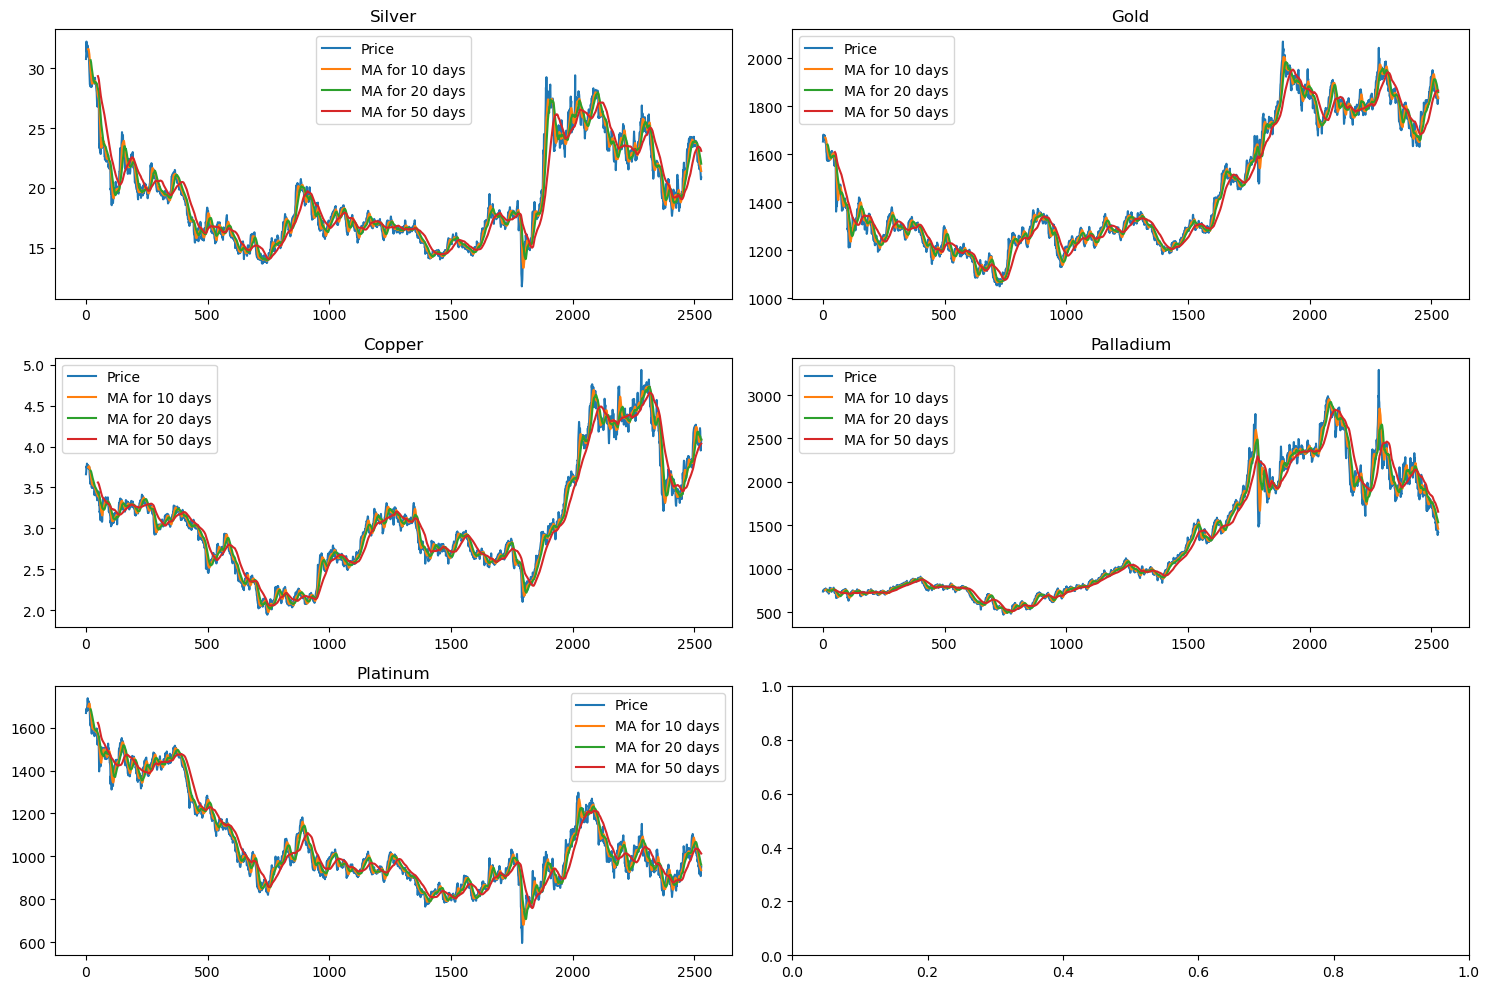

In [32]:
ma_day = [10, 20, 50]

metals = [imputed_df_silver, imputed_df_gold, imputed_df_copper, imputed_df_palladium, imputed_df_platinum]

for ma in ma_day:
    for metal in metals:
        column_name = f"MA for {ma} days"
        metal[column_name] = metal['Price'].rolling(ma).mean()
        
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

imputed_df_silver[:][['Price', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('Silver')

imputed_df_gold[:][['Price', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('Gold')

imputed_df_copper[:][['Price', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('Copper')

imputed_df_palladium[:][['Price', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('Palladium')

imputed_df_platinum[:][['Price', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[2,0])
axes[2,0].set_title('Platinum')

fig.tight_layout()


#### MA Conclusion
- The significant difference between Price and MA for 50 days of Palladium indicates a higher volatility.
- There is trend confirmation for 2020 (maybe covid effect) showing clearly in all metals, except for Platinum.

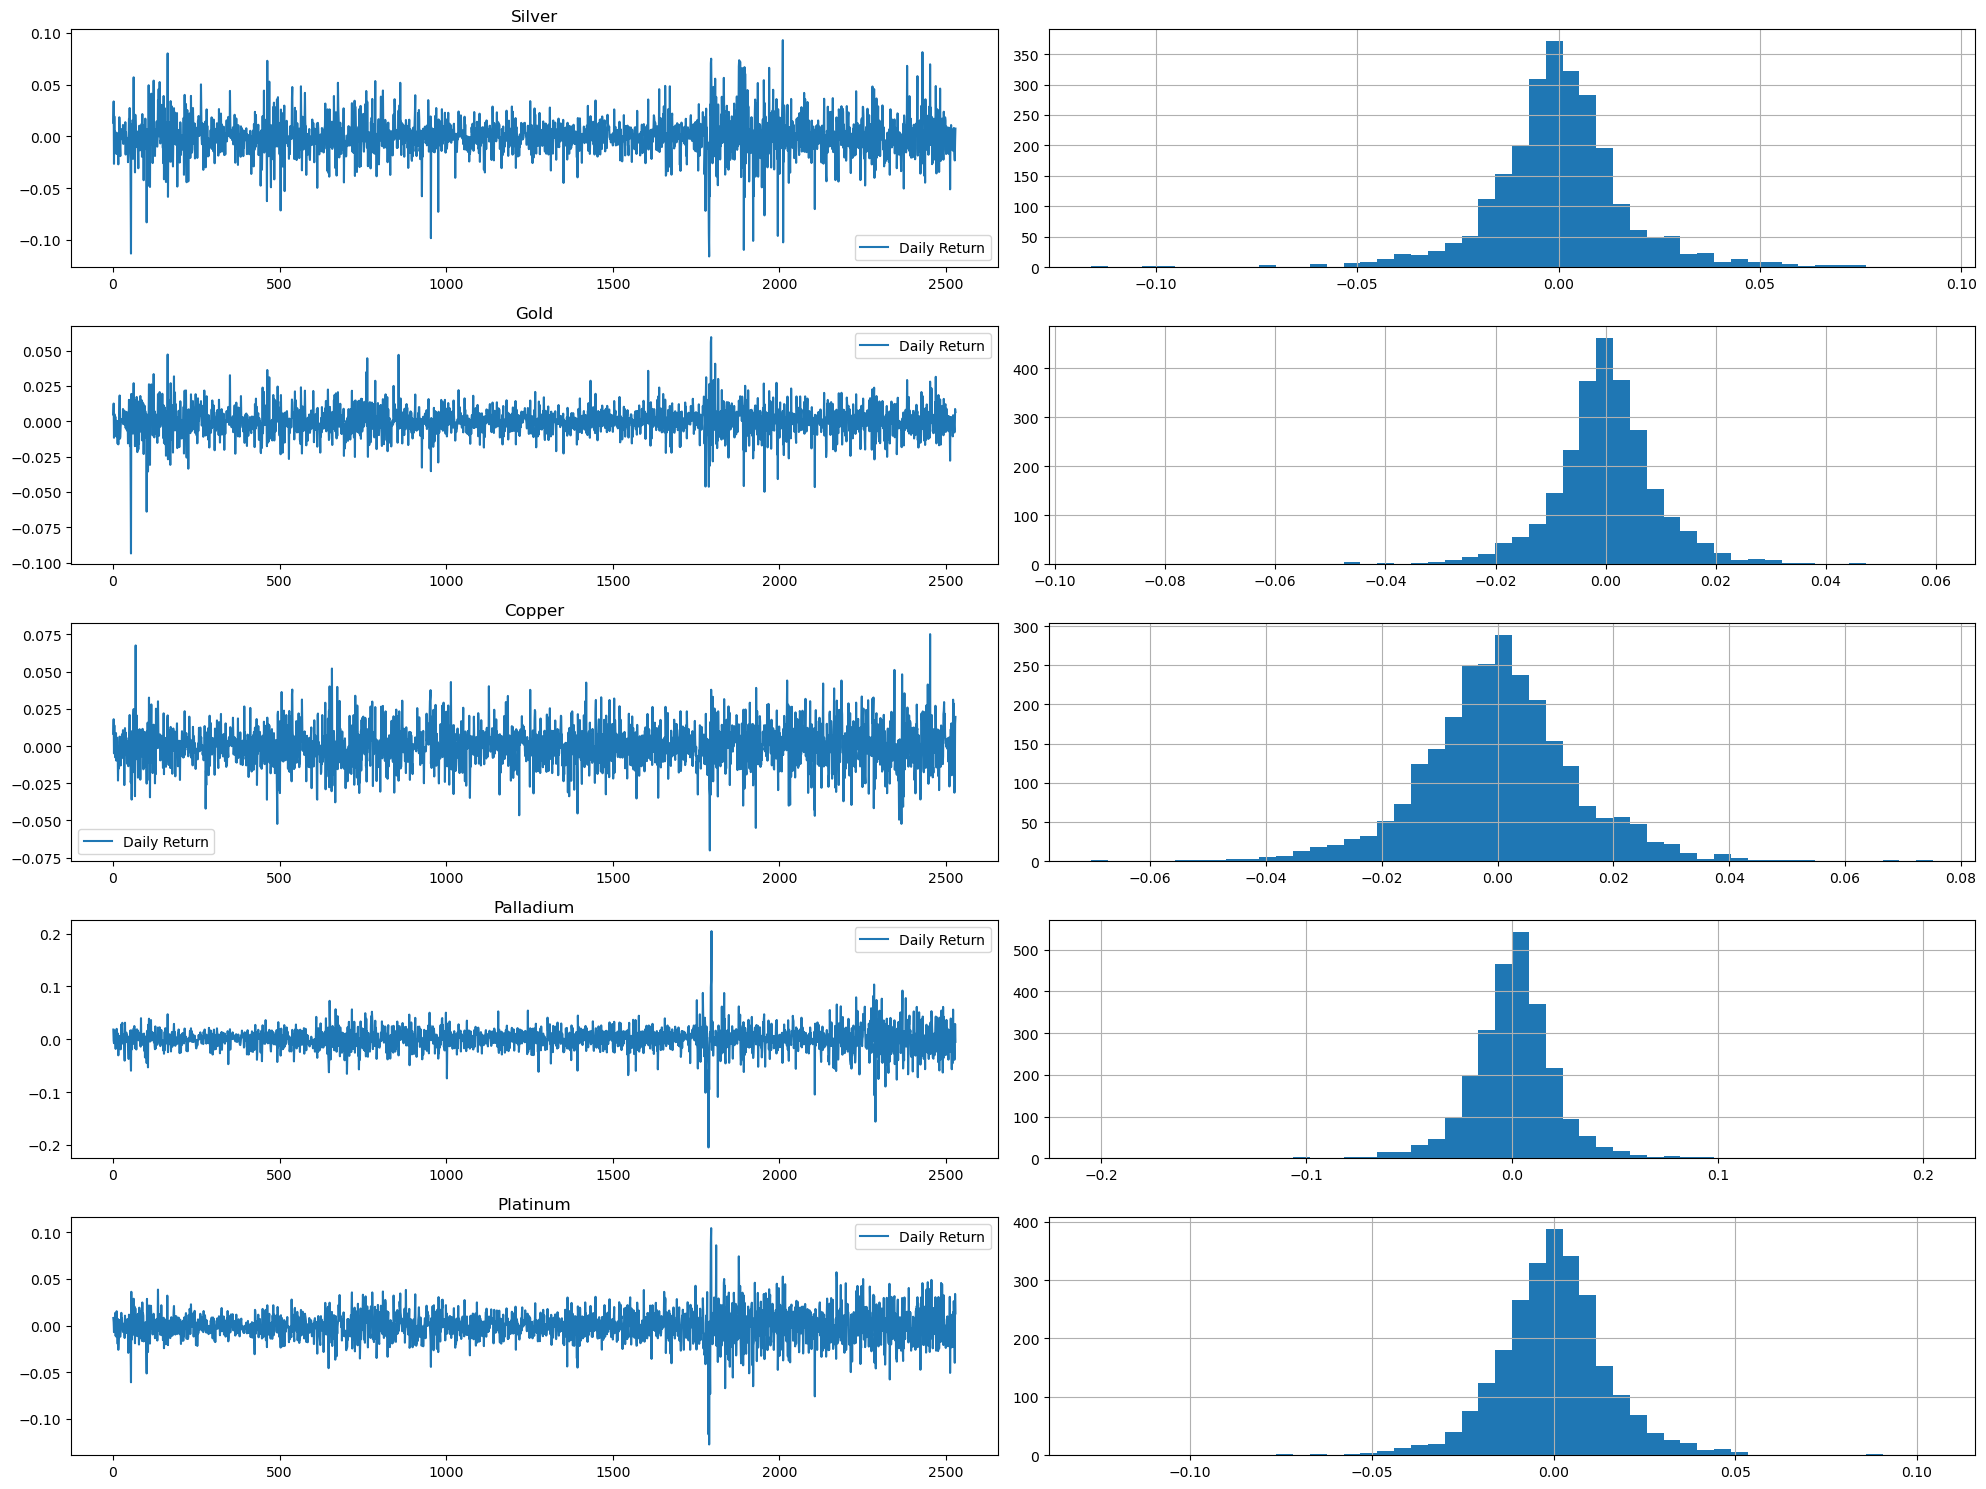

In [21]:
# Percentage of change of each day
metals = [imputed_df_silver, imputed_df_gold, imputed_df_copper, imputed_df_palladium, imputed_df_platinum]

for metal in metals:
    metal['Daily Return'] = metal['Price'].pct_change()
        
fig, axes = plt.subplots(nrows=5, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(20)

imputed_df_silver[['Daily Return']].plot(ax=axes[0,0])
imputed_df_silver['Daily Return'].hist(bins=50, ax=axes[0, 1])
axes[0,0].set_title('Silver')

imputed_df_gold[['Daily Return']].plot(ax=axes[1,0])
imputed_df_gold['Daily Return'].hist(bins=50, ax=axes[1, 1])
axes[1,0].set_title('Gold')

imputed_df_copper[['Daily Return']].plot(ax=axes[2,0])
imputed_df_copper['Daily Return'].hist(bins=50, ax=axes[2, 1])
axes[2,0].set_title('Copper')

imputed_df_palladium[['Daily Return']].plot(ax=axes[3,0])
imputed_df_palladium['Daily Return'].hist(bins=50, ax=axes[3, 1])
axes[3,0].set_title('Palladium')

imputed_df_platinum[['Daily Return']].plot(ax=axes[4,0])
imputed_df_platinum['Daily Return'].hist(bins=50, ax=axes[4, 1])
axes[4,0].set_title('Platinum')

fig.tight_layout()

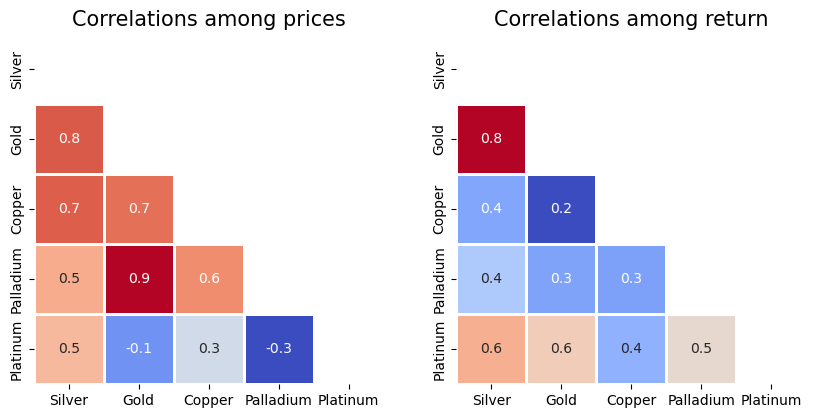

In [ ]:
# Correlation of Data
price_corr = pd.concat([imputed_df_silver['Price'], imputed_df_gold['Price'], imputed_df_copper['Price'], imputed_df_palladium['Price'], imputed_df_platinum['Price']], axis=1)
price_corr.columns = ['Silver', 'Gold', 'Copper', 'Palladium', 'Platinum']

a = price_corr.copy()
a = a.corr()
mask = np.triu(a.corr())

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among prices",fontsize = 15)

return_corr = pd.concat([imputed_df_silver['Daily Return'], imputed_df_gold['Daily Return'], imputed_df_copper['Daily Return'], imputed_df_palladium['Daily Return'], imputed_df_platinum['Daily Return']], axis=1)
return_corr.columns = ['Silver', 'Gold', 'Copper', 'Palladium', 'Platinum']

b = return_corr.copy()
b = b.corr()
mask = np.triu(b.corr())

plt.subplot(2, 2, 2)
sns.heatmap(b,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among return",fontsize = 15)

plt.show()

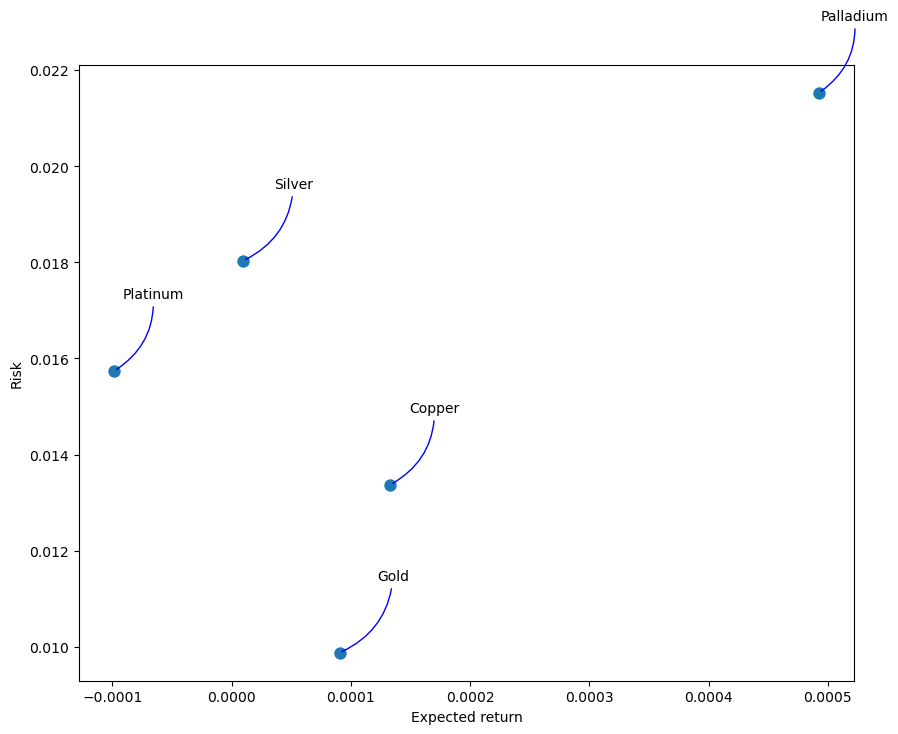

In [ ]:
# Risk
rets = return_corr.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

### Percentage of change Conclusion

- The distributions look normal, with a little difference from Copper that has more spread, while others are thiner.
- We need to check the possibility of random walk like in stocks because there could be a lot of randomness involved.

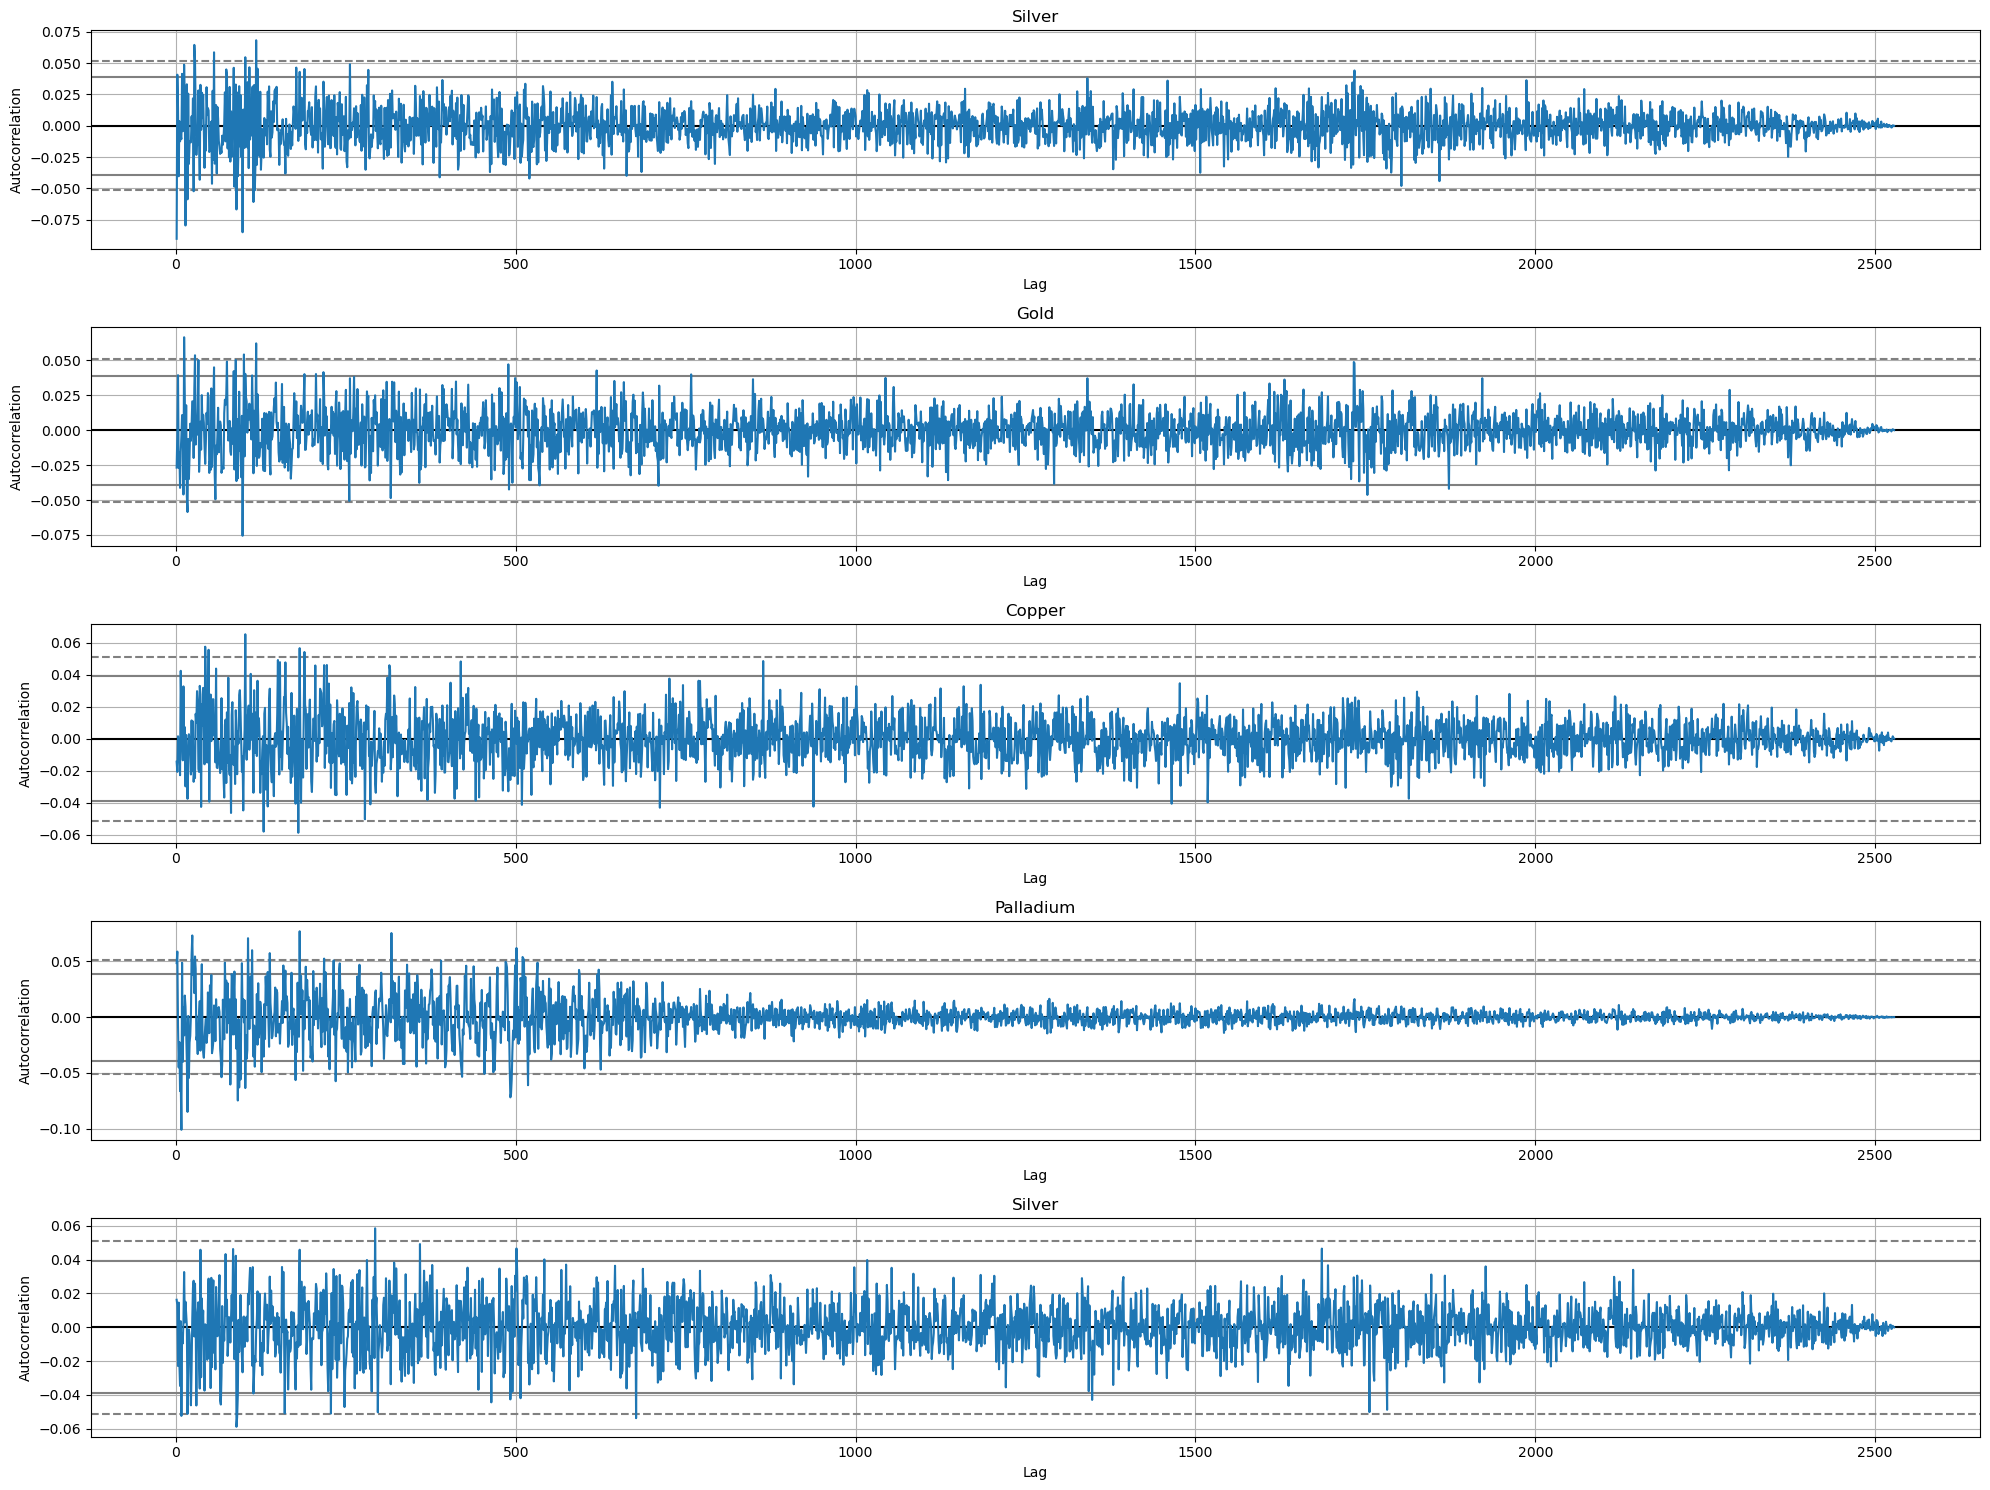

In [58]:
# But, is this data random?
diff_data = []

for metal in metals:
    metaldiff = metal['Price'].diff()
    metaldiff = metaldiff.dropna()
    diff_data.append(pd.DataFrame(metaldiff))

fig, axes = plt.subplots(nrows=5)
fig.set_figheight(15)
fig.set_figwidth(20)

pd.plotting.autocorrelation_plot(diff_data[0], ax=axes[0])
axes[0].set_title('Silver')

pd.plotting.autocorrelation_plot(diff_data[1], ax=axes[1])
axes[1].set_title('Gold')

pd.plotting.autocorrelation_plot(diff_data[2], ax=axes[2])
axes[2].set_title('Copper')

pd.plotting.autocorrelation_plot(diff_data[3], ax=axes[3])
axes[3].set_title('Palladium')

pd.plotting.autocorrelation_plot(diff_data[4], ax=axes[4])
axes[4].set_title('Silver')

fig.tight_layout()

### ACF and PACF

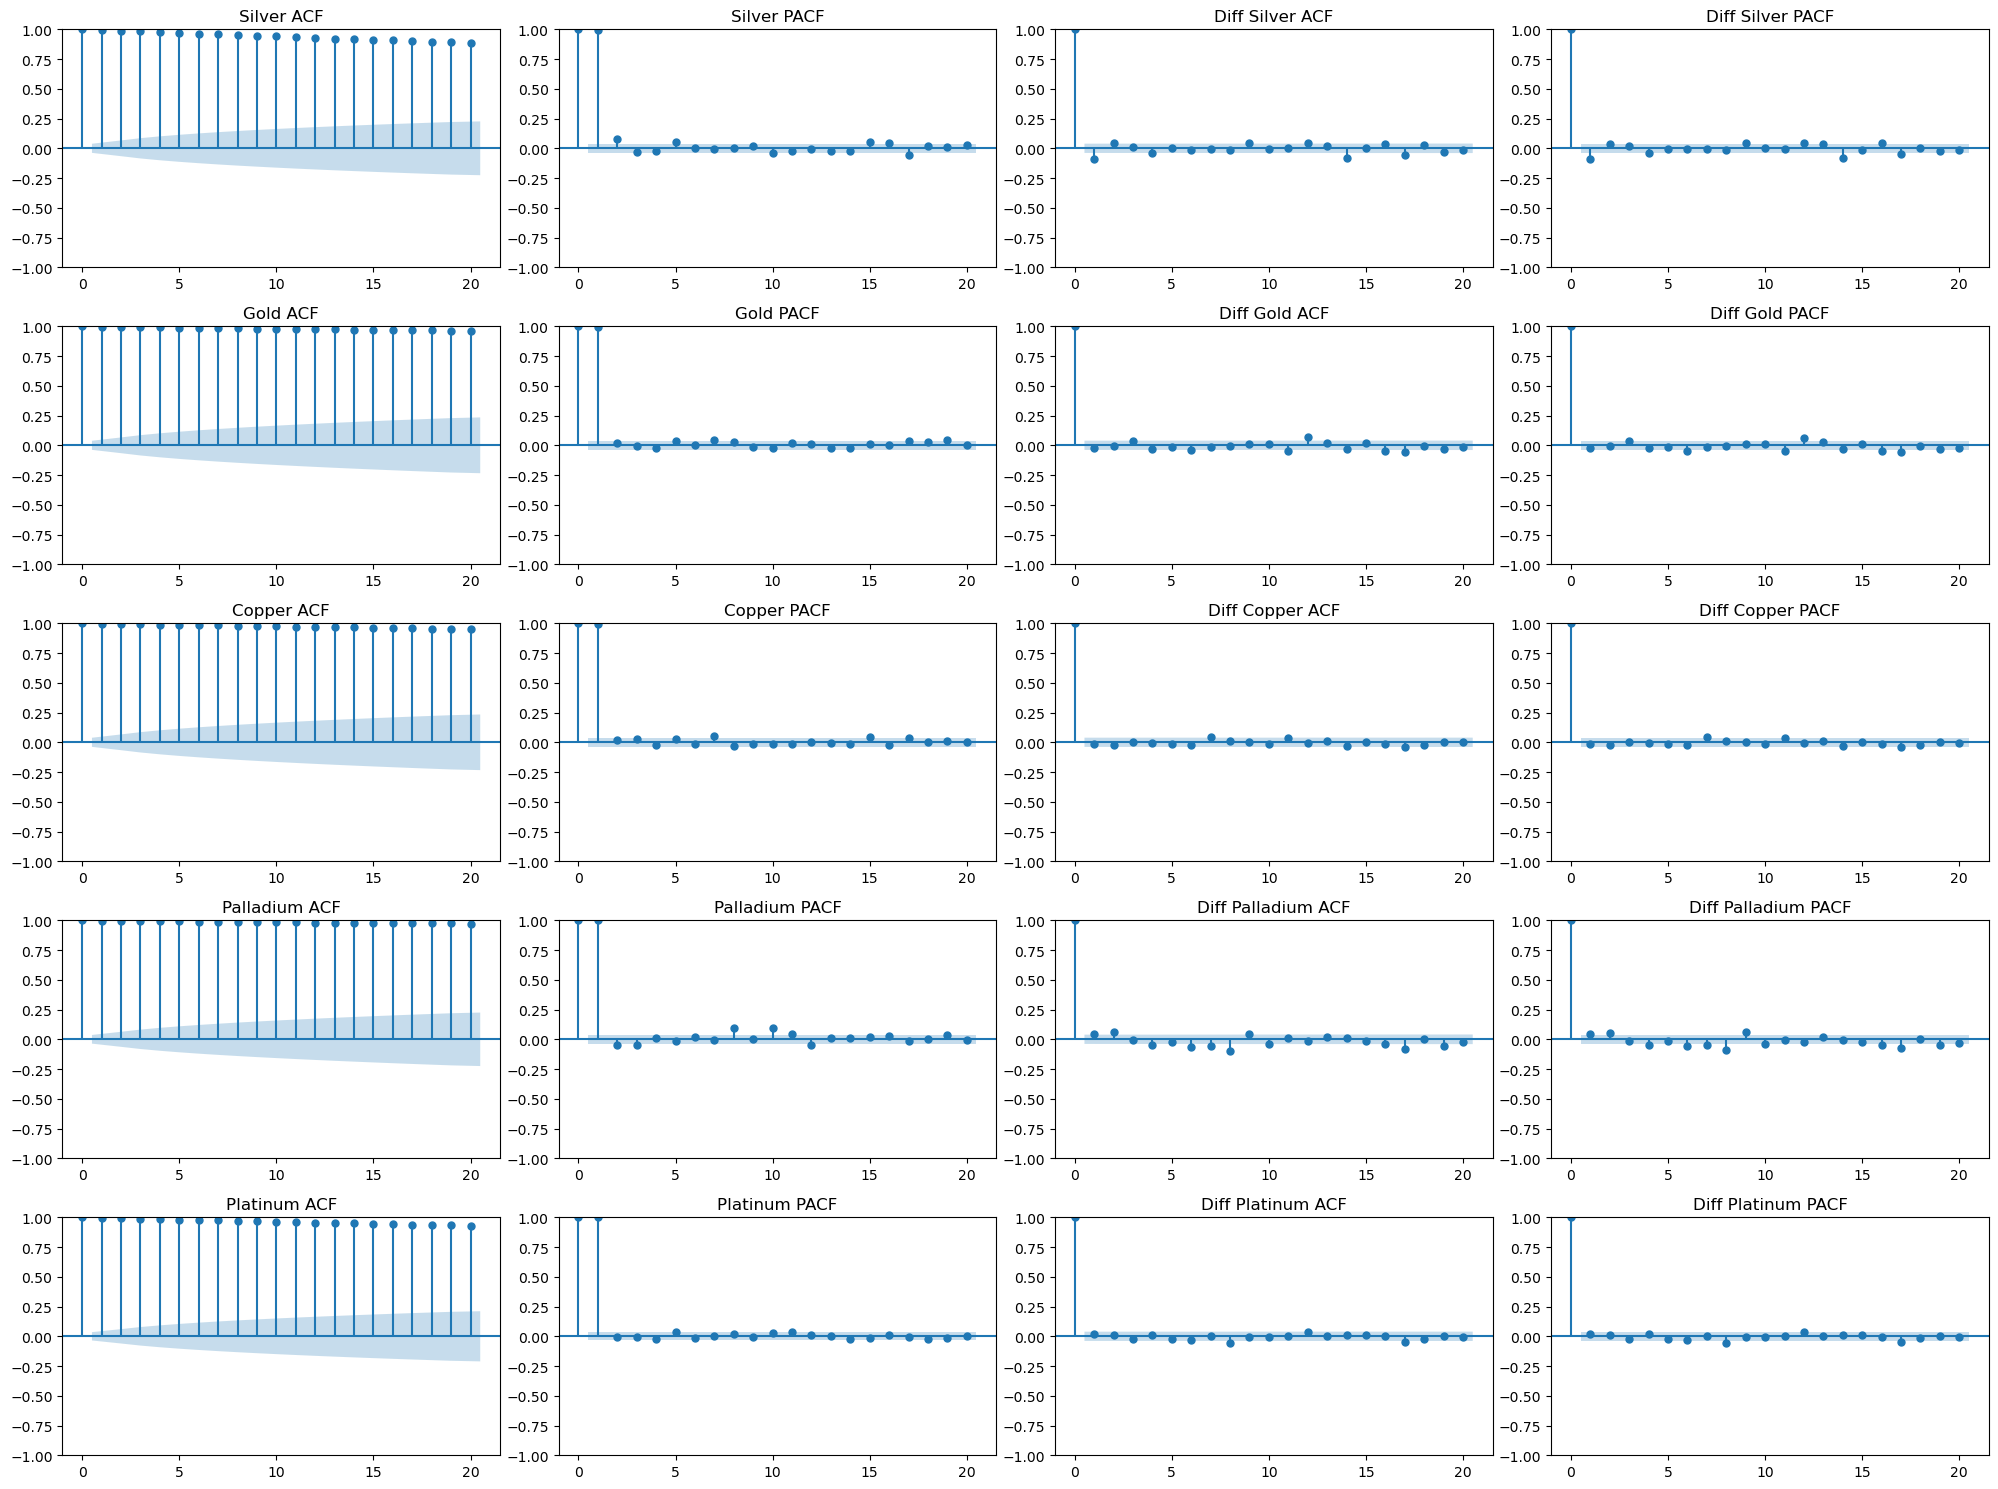

In [59]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

n_lags = 20

f, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))

plot_acf(silver['Price'],lags=n_lags, ax=ax[0, 0])
plot_pacf(silver['Price'],lags=n_lags, ax=ax[0, 1], method='ols')
plot_acf(diff_data[0],lags=n_lags, ax=ax[0, 2])
plot_pacf(diff_data[0],lags=n_lags, ax=ax[0, 3], method='ols')
ax[0,0].set_title('Silver ACF')
ax[0,1].set_title('Silver PACF')
ax[0,2].set_title('Diff Silver ACF')
ax[0,3].set_title('Diff Silver PACF')

plot_acf(gold['Price'],lags=n_lags, ax=ax[1, 0])
plot_pacf(gold['Price'],lags=n_lags, ax=ax[1, 1], method='ols')
plot_acf(diff_data[1],lags=n_lags, ax=ax[1, 2])
plot_pacf(diff_data[1],lags=n_lags, ax=ax[1, 3], method='ols')
ax[1,0].set_title('Gold ACF')
ax[1,1].set_title('Gold PACF')
ax[1,2].set_title('Diff Gold ACF')
ax[1,3].set_title('Diff Gold PACF')

plot_acf(copper['Price'],lags=n_lags, ax=ax[2, 0])
plot_pacf(copper['Price'],lags=n_lags, ax=ax[2, 1], method='ols')
plot_acf(diff_data[2],lags=n_lags, ax=ax[2, 2])
plot_pacf(diff_data[2],lags=n_lags, ax=ax[2, 3], method='ols')
ax[2,0].set_title('Copper ACF')
ax[2,1].set_title('Copper PACF')
ax[2,2].set_title('Diff Copper ACF')
ax[2,3].set_title('Diff Copper PACF')

plot_acf(palladium['Price'],lags=n_lags, ax=ax[3, 0])
plot_pacf(palladium['Price'],lags=n_lags, ax=ax[3, 1], method='ols')
plot_acf(diff_data[3],lags=n_lags, ax=ax[3, 2])
plot_pacf(diff_data[3],lags=n_lags, ax=ax[3, 3], method='ols')
ax[3,0].set_title('Palladium ACF')
ax[3,1].set_title('Palladium PACF')
ax[3,2].set_title('Diff Palladium ACF')
ax[3,3].set_title('Diff Palladium PACF')

plot_acf(platinum['Price'],lags=n_lags, ax=ax[4, 0])
plot_pacf(platinum['Price'],lags=n_lags, ax=ax[4, 1], method='ols')
plot_acf(diff_data[4],lags=n_lags, ax=ax[4, 2])
plot_pacf(diff_data[4],lags=n_lags, ax=ax[4, 3], method='ols')
ax[4,0].set_title('Platinum ACF')
ax[4,1].set_title('Platinum PACF')
ax[4,2].set_title('Diff Platinum ACF')
ax[4,3].set_title('Diff Platinum PACF')

plt.tight_layout()
plt.show()

### Analysis
- Given the ACF and PACF results, the data is considered to be Random Walk, which means it cannot be reasonably predicted.
- What we can do is use a function on the observations on the previous setps for the next time step.